In [1]:
import hc_lib.plots.figlib as flib
flib.siteFG()
from figrid.figrid import DataList
from figrid.figrid import Figrid
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter


/software/spack-software/2020.05.14/linux-rhel8-ivybridge/gcc-8.4.0/python-3.7.7-zgcjuclie3fiis4ljkrfp4c4j6fkoa62/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
box = 'tng100'
snap = [99, 67]
axis = 0
res = 800
files = ['hiptlXgalaxy', 'vnXgalaxy']
master = DataList()
for f in files:
    for s in snap:
        rlib = flib.load(box, s, axis, res, f)
        kmin = rlib.results['pk'][0].xvalues[0]
        BOX = rlib.results['pk'][0].props['box']
        RES = rlib.results['pk'][0].props['grid_resolution']
        master.loadResults(rlib.results['pk'])

smfont = 10
larfont = 12
cdict = flib.getCdict()
real_color = cdict['real']
redshift_color = cdict['redshift']
blue_color = cdict['blue']
red_color = cdict['red']
XBORDER, YBORDER = flib.getBorders()
XLIM = flib.getXlim()

In [3]:
def color_compare(ip, window_length, polyorder, savename):
    print('MAKING COLOR COMPARISON')
    def _smooth(ax, data, kwargs):
        data = np.array(data)
        x = data[0, :]
        print('used filter')
#         polyorder = 1
#         window_length = 7
#         cutidx = 0
        ymin = savgol_filter(data[1, :], window_length, polyorder)
        ymax = savgol_filter(data[2, :], window_length, polyorder)
#         minplt = np.zeros_like(x)
#         maxplt = np.zeros_like(x)
#         minplt[:cutidx] = data[1, :cutidx]
#         maxplt[:cutidx] = data[2, :cutidx]
#         minplt[cutidx:] = ymin
#         maxplt[cutidx:] = ymax
        ax.fill_between(x, ymin, ymax, **kwargs)      
        return
    
    # make ratios
    dl = DataList(master.getMatching(ip))
    rob = flib.makeBlueRedRatio(dl)
    robdl = DataList(rob)
    
    
    fgrob = Figrid(robdl)
    fgrob.arrange('ratio', '', panel_length = 2)
    fkw = {}
    fkw['label'] = 'Real Space'
    fkw['color'] = real_color
    fkw['alpha'] = 0.35
    fgrob.makeFills({'space':'real'}, fkw)
    fkw['label'] = 'Redshift Space'
    fkw['color'] = redshift_color
    fgrob.makeFills({'space':'redshift'}, fkw)
    
    fgrob.setFunc({'figrid_process':'fill'}, _smooth)
    fgrob.plot()

    dl = DataList(master.getMatching(ip))
    fg = Figrid(dl)
    fg.setColOrder(['real', 'redshift'])
    fg.arrange('space', '', panel_length = 2, xborder = XBORDER,
            yborder = YBORDER)
    pargs = {}
    pargs['label'] = 'HI X Blue Cross-Power'
    pargs['color'] = blue_color
    pargs['alpha'] = 0.55
    fg.makeFills({'color':'blue'}, pargs)
    pargs['label'] = 'HI X Red Cross-Power'
    pargs['color'] = red_color
    fg.makeFills({'color':'red'}, pargs)
    fg.combineFigrids(fgrob)
    
    fg.plot()

    redslc = (slice(1,fg.dim[0]-1), slice(None))
    realslc = (slice(0, 1), slice(None))
    # fix the axes
    axparams = {}
    flib.setNyq(fg, kmin, RES, BOX)
    axparams['xscale'] = 'log'
    axparams['ylim'] = [0, 2]
    fg.setAxisParams(axparams)
    axparams['yscale'] = 'log'
    axparams['ylim'] = [0.1, 1e4]
    fg.setAxisParams(axparams, slc=redslc)
    axparams['ylim'] = [1, 1e4]
    fg.setAxisParams(axparams, slc = realslc)
    # fix the tick labels
    fg.setDefaultTicksParams()
    fg.setTicks({'labelsize':smfont, 'direction':'in'})
    # labels
    kw = {'fontsize':larfont}
    pknum = fg.dim[0] - 1
    ypos = [fg.xborder[0] * 0.1 / fg.figsize[0], 
        1 - (0.5*(np.sum(fg.panel_heights[:-1]) + np.sum(fg.hspace[:fg.dim[1] - 2]) + fg.yborder[0])) / fg.figsize[1]]
    ykw = {'fontsize':larfont, 'ha':'left'}
    flib.pklabels(fg, ysub = r'\rm{HIXgal}', ypos = ypos, xtxtkw = kw, ytxtkw = ykw)
    txtkw = {}
    txtkw['ha'] = 'center'
    txtkw['va'] = 'top'
    txtkw['fontsize'] = smfont
#     lra = r'$\longleftrightarrow$'
    fg.setRowLabels(['Real Space', 'Redshift Space', 'Color Ratio'], [0.5, 0.95],
                txtkw)
    fg.makeYLabel(r'P$_{\rm{red}}$ (k) / P$_{\rm{blue}}$ (k)', 
                [ypos[0], (0.5 * fg.panel_heights[-1] + fg.yborder[1]) / fg.figsize[1]], 
                {'va':'center', 'ha':'center', 'fontsize':larfont})
    lkw = {'frameon':False, 'fontsize':smfont - 1, 'loc':'lower left'}
    fg.drawLegend(lkw, (0,0))
    # lkw['loc'] = 'center right'
    fg.drawLegend(lkw, (2,0))
    fcolors = np.empty(fg.dim, dtype = object)
    trgba = mpl.colors.to_rgba
    alpha = 0.3
    fcolors[:,0] = [trgba(real_color, alpha), trgba(redshift_color, alpha), trgba('white')]
    flib.setFacecolor(fg, fcolors)
    flib.plotOnes(fg, (fg.dim[0]-1,0))
    fg.save(savename)
    fg.clf()
    return

MAKING COLOR COMPARISON
The row values for ['ratio']: ['no key found']
The column values for ['']: ['no key found']
used filter
used filter
The row values for ['space']: ['real', 'redshift']
The column values for ['']: ['no key found']
[0.22 0.22]
[]
used filter
used filter
MAKING COLOR COMPARISON
The row values for ['ratio']: ['no key found']
The column values for ['']: ['no key found']
used filter
used filter
The row values for ['space']: ['real', 'redshift']
The column values for ['']: ['no key found']
[0.22 0.22]
[]
used filter
used filter
MAKING COLOR COMPARISON
The row values for ['ratio']: ['no key found']
The column values for ['']: ['no key found']
used filter
used filter
The row values for ['space']: ['real', 'redshift']
The column values for ['']: ['no key found']
[0.22 0.22]
[]
used filter
used filter
MAKING COLOR COMPARISON
The row values for ['ratio']: ['no key found']
The column values for ['']: ['no key found']
used filter
used filter
The row values for ['space']: ['rea

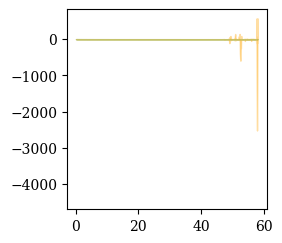

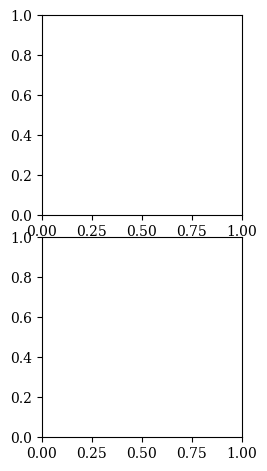

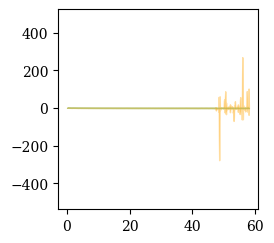

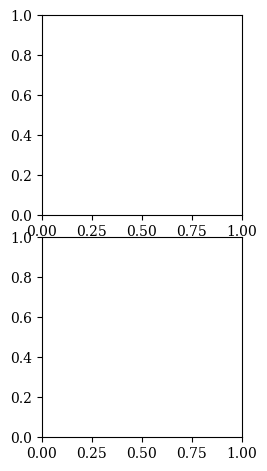

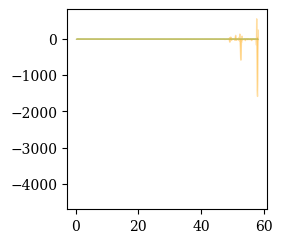

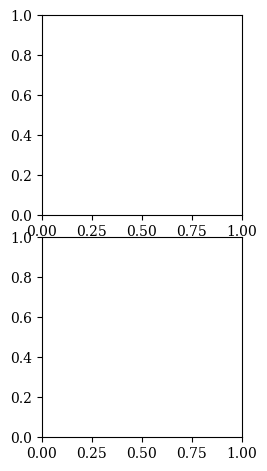

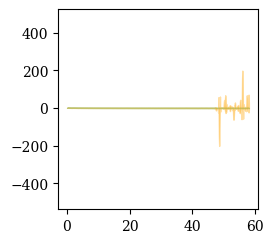

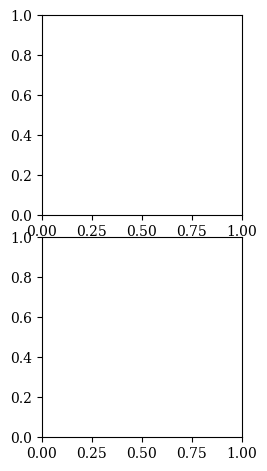

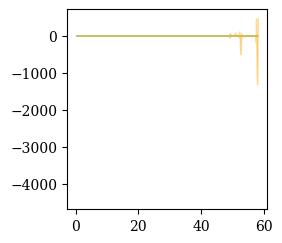

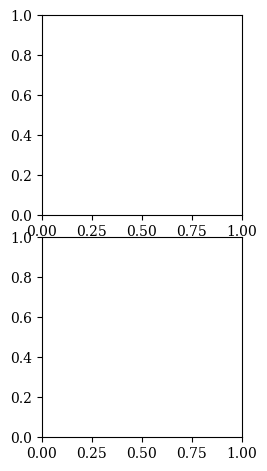

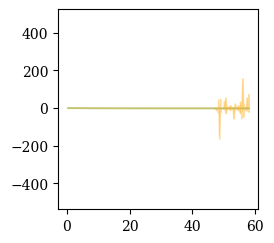

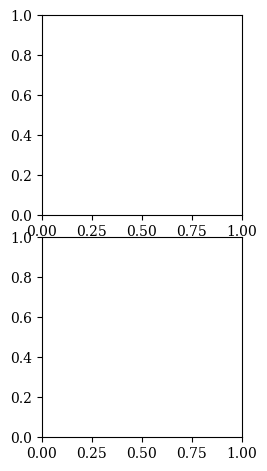

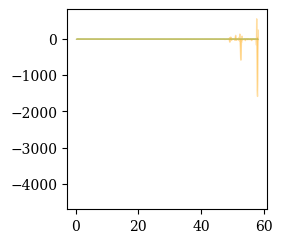

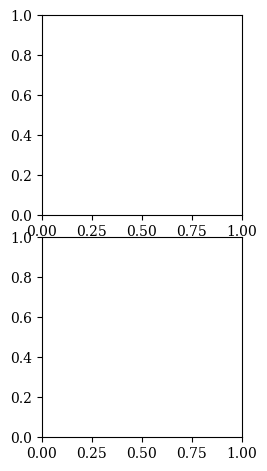

In [4]:
# the red vs blue ratios don't make a lot of sense with the ratios
wls = [7, 9, 11]
pl = [4]
ip = {'color':['red', 'blue'], 'gal_res':'diemer', 'gal_species':'stmass', 'is_auto':False}

for wl in wls:
    for p in pl:
        for ss in [99, 67]:
            ip['snapshot'] = ss
            name = 'redvsblue_w%d_p%d_%03d.png'%(wl, p, ss)
            if wl > p:
                color_compare(ip, wl, p, name)
ip['snapshot'] = 99
color_compare(ip, 9, 4, "rvb_99_FINAL.pdf")         

In [5]:

def smooth_compare(window_length, polyorder, name):
    print('MAKING SMOOTHING COMPARISON')
    def _smooth(ax, data, wl, po):
        x = data[0]
        label = 'window%d_poly%d'%(wl, po)
        y = savgol_filter(data[1], wl, po)
        ax.plot(x, y, label = label)      
        return      
    models = master.getAttrs()
    print(models)
    ip = {'snapshot':99, 'HI_fieldname':'vn',
         'gal_res':'diemer', 'color_cut':'0.60'}
    dl = DataList(master.getMatching(ip))
    rob = flib.makeBlueRedRatio(dl)
    for r in rob:
        print(r.attrs)
    fig, axs = plt.subplots(1, 2, figsize = [10, 5])
    for i in [0,1]:
#         print(rob[i].data)
        axs[i].plot(rob[i].data[0], rob[i].data[1], linestyle = '--')
    for wl in window_length:
        for po in polyorder:
            for i in [0, 1]:
                    p = axs[i]
                    data = rob[i].data
                    if wl > po:
                        _smooth(p, data, wl, po)
                    p.set_xscale('log')
                    p.set_ylim(0, 2)
                    p.set_xlim(0.1, 20)

    
    axs[0].legend()

    fig.savefig(name)
    return

MAKING SMOOTHING COMPARISON
['result_runtime', 'is_auto', 'box', 'simname', 'sim_resolution', 'num_part', 'grid_resolution', 'snapshot', 'redshift', 'axis', 'fieldname', 'is_hydrogen', 'is_atomic', 'is_molecular', 'is_particle', 'is_groupcat', 'is_matter', 'mas', 'space', 'compute_xi', 'compute_slice', 'color', 'gal_species', 'gal_res', 'color_cut', 'map', 'model', 'HI_fieldname']
{'is_auto': False, 'box': 75.0, 'simname': 'tng100', 'sim_resolution': 'high', 'num_part': 1733600704, 'grid_resolution': 800, 'snapshot': 99, 'redshift': 2.220446049250313e-16, 'axis': 0, 'fieldname': 'vn_galaxy', 'is_hydrogen': 'True_False', 'is_atomic': 'True_False', 'is_molecular': False, 'is_particle': 'True_False', 'is_groupcat': 'False_True', 'is_matter': 'False_True', 'mas': 'CICW', 'space': 'real', 'compute_xi': False, 'compute_slice': True, 'gal_species': 'stmass', 'gal_res': 'diemer', 'map': 'mass', 'HI_fieldname': 'vn', 'color': 'ratio'}
{'is_auto': False, 'box': 75.0, 'simname': 'tng100', 'sim_re

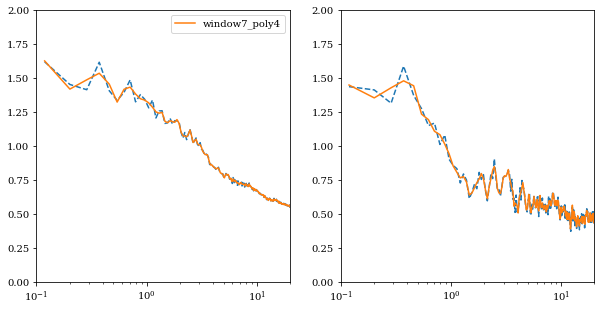

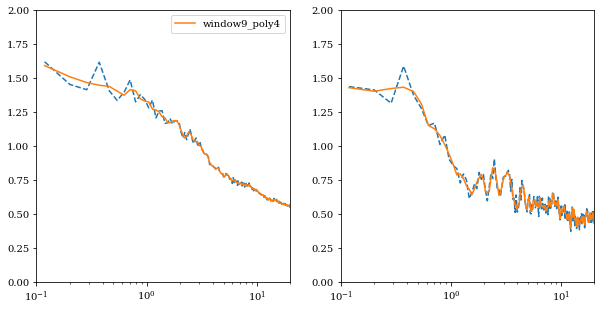

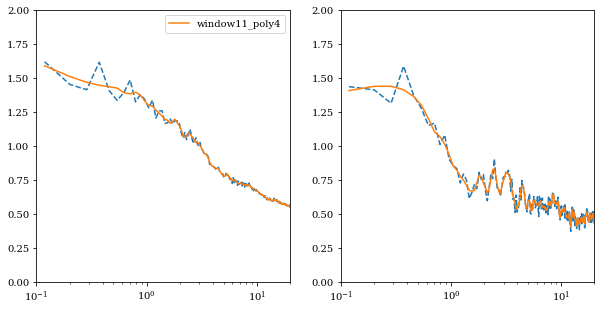

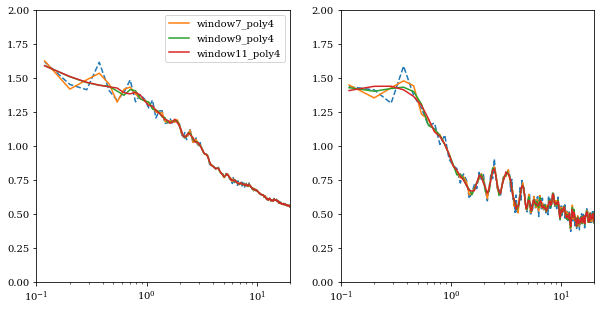

In [6]:
for wl in wls:
    smooth_compare([wl], pl, 'smooth_compare_window%d.png'%wl)
for p in pl:
    smooth_compare(wls, [p], 'smooth_compare_polynomial%d.png'%p)

In [7]:
def redshift_evo(ip, savename, withratio):
    print('MAKING REDSHIFT EVOLUTION FIGURE')
    rbonly = DataList(master.getMatching(ip))
    withrat = flib.makeBlueRedRatio(rbonly)
    if withratio:
        rbonly.dclist.extend(withrat)

    fg = Figrid(rbonly)
    fg.setRowOrder(['real', 'redshift'])
    if withratio:
        fg.setColOrder(['blue', 'red', 'ratio'])
    else:
        fg.setColOrder(['blue', 'red'])
    XBORDER[0] = 0.35
    YBORDER[1] = 0.35
    fg.arrange('color', 'space', panel_length = 2, xborder = XBORDER, 
            yborder = YBORDER)
    zcols = flib.getCdict()['zevo']
    for rv in fg.rowValues:
        if rv in zcols:
            pargs = {}
            pargs['label'] = 'z=0.0'
            pargs['color'] = zcols[rv][0]
            pargs['alpha'] = 0.55
            fg.makeFills({'snapshot': 99, 'color':rv}, pargs)
            pargs['label'] = 'z=0.5'
            pargs['color'] = zcols[rv][1]
            fg.makeFills({'snapshot':67, 'color':rv}, pargs)
        
    
    fg.plot()
    pkslc = (slice(0,2), slice(None))
    # fix the axes
    axparams = {}
    flib.setNyq(fg, kmin, RES, BOX)
    axparams['xscale'] = 'log'
    axparams['ylim'] = [0, 2]
    fg.setAxisParams(axparams)
    axparams['yscale'] = 'log'
    axparams['ylim'] = [0.1, 1e4]
    fg.setAxisParams(axparams, slc=pkslc)
    # axparams['ylim'] = [1, 1e4]
    # fg.setAxisParams(axparams, slc=(slice(0,1), slice(0,2)))
    # fix the tick labels
    fg.setDefaultTicksParams()
    fg.setTicks({'labelsize':smfont, 'direction':'in'})
    # labels
    kw = {'fontsize':larfont}
    if withratio:
        ypos = [fg.xborder[0] * 0.1 / fg.figsize[0], 
                1 - (0.5*(np.sum(fg.panel_heights[:-1]) + np.sum(fg.hspace[:fg.dim[1] - 2]) + fg.yborder[0])) / fg.figsize[1]]
    else:
        labely = 0.5
        ypos = [fg.xborder[0] * 0.1 / fg.figsize[0], 1 - labely]
    flib.pklabels(fg, ysub = r'\rm{HIXgal}', ypos = ypos, xtxtkw = kw, ytxtkw = kw)
    txtkw = {}
    txtkw['ha'] = 'center'
    txtkw['va'] = 'top'
    txtkw['fontsize'] = smfont
    lra = r'$\longleftrightarrow$'
    if withratio:
        fg.setRowLabels(['Blue Galaxies' + lra, 'Red Galaxies' + lra, 'Color Ratio' + lra], [0.5, 0.95],
                txtkw)
    else:
        fg.setRowLabels(['Blue Galaxies' + lra, 'Red Galaxies' + lra], [0.5, 0.95],
                txtkw)
    txtkw['ha'] = 'left'
    txtkw['va'] = 'bottom'
    uda = r'$\updownarrow$'
    fg.setColLabels(['Real Space' + uda, 'Redshift Space' + uda], [0.05, 0.05], txtkw)
    if withratio:
        fg.makeYLabel(r'P$_{\rm{red}}$ (k) / P$_{\rm{blue}}$ (k)', 
                [ypos[0], (0.5 * np.sum(fg.panel_heights[-1]) + fg.yborder[1]) / fg.figsize[1]], 
                {'va':'center', 'fontsize':larfont})
    lkw = {'frameon':False, 'fontsize':smfont - 1, 'loc':'lower left'}
    fg.drawLegend(lkw, (1,1))
    lkw['loc'] = 'center right'
    # fg.drawLegend(lkw, (2,0))
    if withratio:
        for i in range(2):
            flib.plotOnes(fg, (2, i))
    # fcolors[:,0] = [trgba('blue', alpha), trgba('red', alpha), trgba('white')]
    # flib.setFacecolor(fg, fcolors)
    fg.save(savename)
    fg.clf()
    return

for wr in [True, False]:
    if wr:
        wrst = 'withratio'
    else:
        wrst = 'noratio'
    name = 'redvsblue_zevo_%s.png'%wrst
    redshift_evo({'color':['red', 'blue']}, name, wr)

MAKING REDSHIFT EVOLUTION FIGURE
The row values for ['color']: ['blue', 'red', 'ratio']
The column values for ['space']: ['real', 'redshift']
MAKING REDSHIFT EVOLUTION FIGURE
The row values for ['color']: ['blue', 'red']
The column values for ['space']: ['real', 'redshift']


In [8]:
redshift_evo({'color':['red', 'blue']}, 'rvb_redshift_evo_FINAL.pdf', True)

MAKING REDSHIFT EVOLUTION FIGURE
The row values for ['color']: ['blue', 'red', 'ratio']
The column values for ['space']: ['real', 'redshift']
